## Exercise 1.4 Hotdog -- no hotdog
This is the first poster hand-in exercise for the course. Please see the associated PDF for instructions.

In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

We always check that we are running on a GPU

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02516/

In [3]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [4]:
size = 128
train_transform = transforms.Compose([transforms.Resize((size, size)),
                                    transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])

batch_size = 64
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=0)

Let's look at some images from our data 

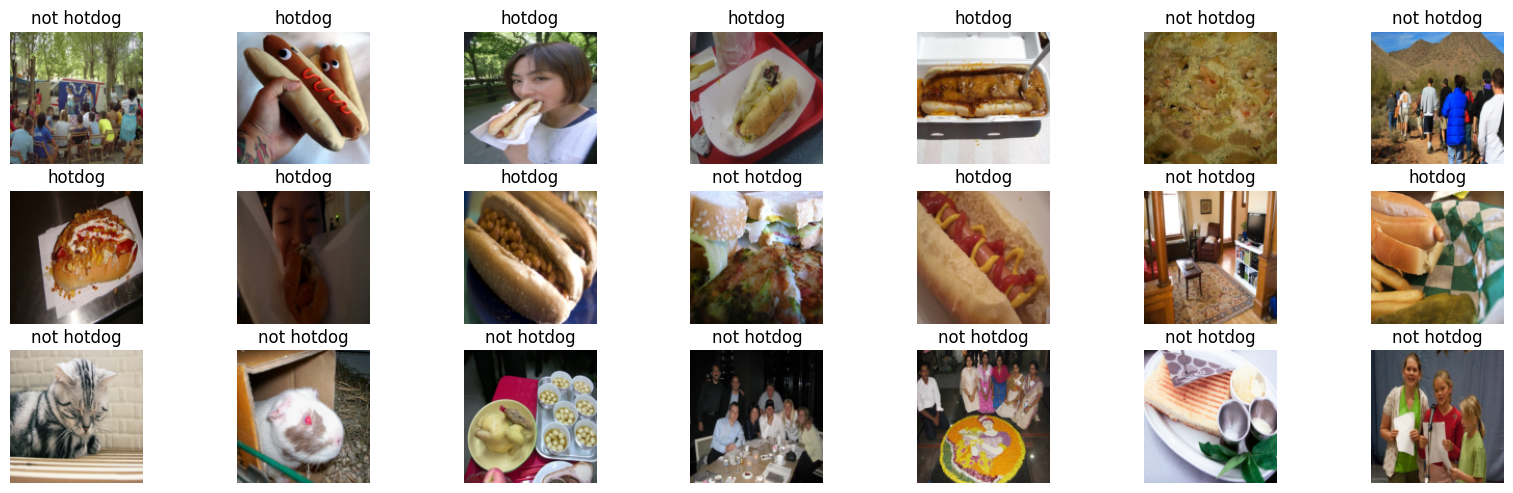

In [5]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')


### EDA

In [6]:
targets_train = [label for _, label in trainset]
targets_test = [label for _, label in testset]

In [7]:
hotdogs_train, hotdogs_test, not_hotdogs_train, not_hotdogs_test = sum(targets_train), sum(targets_test), len(targets_train) - sum(targets_train), len(targets_test) - sum(targets_test)
print(f"Hotdogs in the train set: {hotdogs_train}")
print(f"Not hotdogs in the train set: {not_hotdogs_train}")
print(f"Hotdogs in the test set: {hotdogs_test}")
print(f"Not hotdogs in the test set: {not_hotdogs_test}")


Hotdogs in the train set: 972
Not hotdogs in the train set: 1075
Hotdogs in the test set: 967
Not hotdogs in the test set: 895


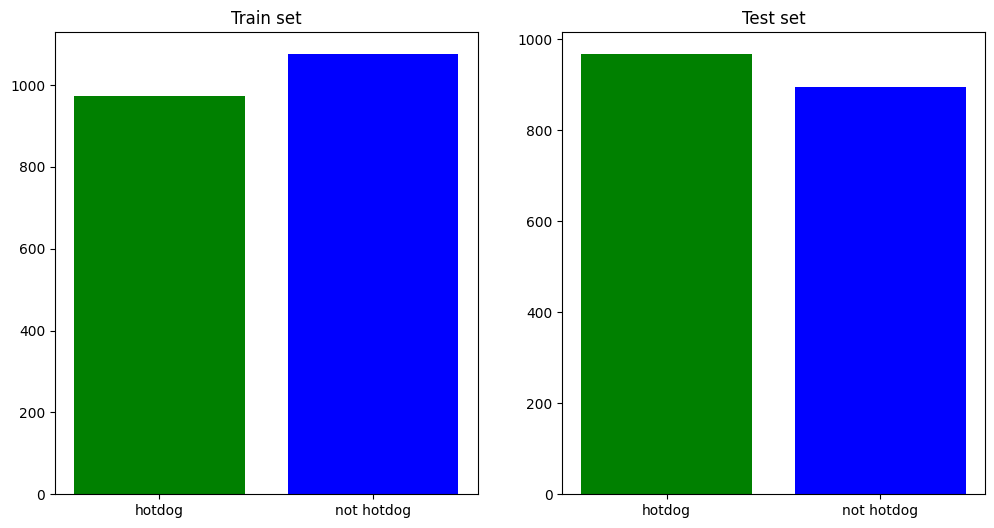

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].bar(['hotdog', 'not hotdog'], [hotdogs_train, not_hotdogs_train], color = ['green', 'blue'])
ax[0].set_title('Train set')
ax[1].bar(['hotdog', 'not hotdog'], [hotdogs_test, not_hotdogs_test], color = ['green', 'blue'])
ax[1].set_title('Test set')
plt.show()

Now create a model and train it!


In [30]:
class Network(nn.Module):
    def __init__(self, num_epochs, learning_rate, batch_size):
        super(Network, self).__init__()
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        self.criterion = nn.CrossEntropyLoss()

        self.convolutional = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # nn.Dropout(0.25),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.linear = nn.Sequential(
            nn.Linear(32*32*32, 128), # 32*32*32 is the size of the tensor after the convolutional part because of the maxpooling
            nn.ReLU(),
            nn.Linear(128, 2)
        )
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        
    def forward(self, x):
        x = self.convolutional(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x
    
    def run(self, train_loader, test_loader):

        for epoch in tqdm(range(self.num_epochs), unit= 'epoch'):
        #for each epoch
            train_correct = 0
            loss_total = 0

            for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
                self.train()
                data, target = data.to(device), target.to(device)
                self.optimizer.zero_grad()
                output = self(data)
                loss = self.criterion(output, target)
                loss_total+= loss.detach().cpu().item()
                loss.backward()
                self.optimizer.step()
                predicted = output.argmax(dim=1)
                train_correct += (target == predicted).sum().cpu().item()

        #test accuracy
            test_correct = 0
            for data, target in test_loader:
                self.eval()
                data = data.to(device)
                with torch.no_grad():
                    output = self(data)
                predicted = output.argmax(dim=1).cpu()
                test_correct += (predicted == target).sum().cpu().item()
                
            test_acc = test_correct/len(testset)
            
            train_acc = train_correct/len(trainset)
            
            print("Accuracy train: {train:.1f}%\t test: {test:.1f}%".format(test=100*test_acc, train=100*train_acc))


In [31]:
num_epochs = 5
learning_rate = 0.001
batch_size = 64
model = Network(num_epochs, learning_rate, batch_size).to(device)
model.run(train_loader, test_loader)


  0%|          | 0/5 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 55.0%	 test: 65.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 68.3%	 test: 72.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 75.1%	 test: 72.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 77.5%	 test: 73.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 78.3%	 test: 73.1%


### TESTING

In [18]:
class Network_(nn.Module):
    def __init__(self):
        super(Network_, self).__init__()
        self.convolutional = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.linear = nn.Sequential(
            nn.Linear(32*32*32, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        x = self.convolutional(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

In [19]:
model = Network_()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


In [20]:
num_epochs = 5
train_accuracy, test_accuracy = [], []
losses = []

for epoch in tqdm(range(num_epochs), unit= 'epoch'):
    #for each epoch
    train_correct = 0
    loss_total = 0

    for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        model.train()
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad
        output = model(data)
        loss = criterion(output, target)
        loss_total+= loss.detach().cpu().item()
        loss.backward()
        optimizer.step()
        predicted = output.argmax(dim=1)
        train_correct += (target == predicted).sum().cpu().item()

    losses.append(loss_total)

    #test accuracy
    test_correct = 0
    for data, target in test_loader:
        model.eval()
        data = data.to(device)
        with torch.no_grad():
            output = model(data)
        predicted = output.argmax(dim=1).cpu()
        test_correct += (predicted == target).sum().cpu().item()
        
    test_acc = test_correct/len(testset)
    test_accuracy.append(test_acc)
    train_acc = train_correct/len(trainset)
    train_accuracy.append(train_acc)
    print("Accuracy train: {train:.1f}%\t test: {test:.1f}%".format(test=100*test_acc, train=100*train_acc))

    




  0%|          | 0/5 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 52.2%	 test: 48.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 52.5%	 test: 48.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 52.5%	 test: 48.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 52.5%	 test: 48.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 52.5%	 test: 48.1%


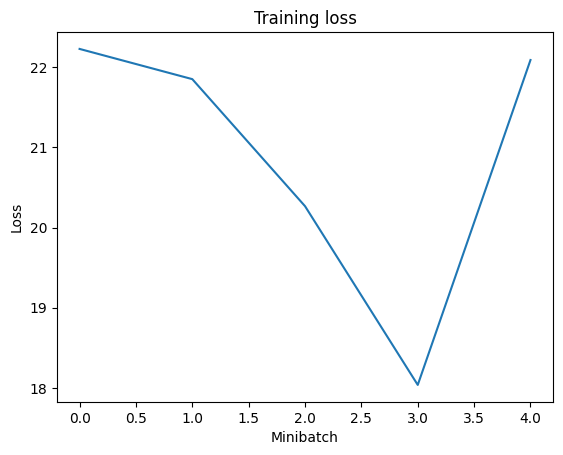

In [92]:
#plot losses
plt.plot(losses)
plt.xlabel('Minibatch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()


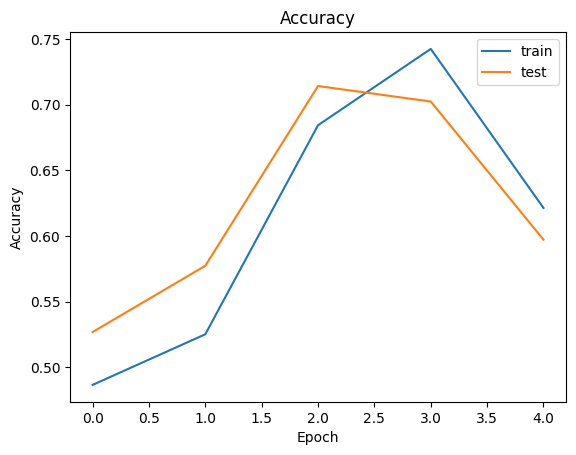

In [93]:
#plot accuracy
plt.plot(train_accuracy, label='train')
plt.plot(test_accuracy, label='test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()


In [ ]:
#demo